# Select Data and IRT model

In [ ]:
# 0 -> bone
# 1 (others) -> brain

#DATA = 0 
DATA = 1


In [ ]:
# 0 -> 1PL-IRT
# 1 (others) -> 2PL-IRT 

#MODEL = 0
MODEL = 1


# Prepare

In [ ]:
! pip install -q pystan==3.3.0 arviz==0.12.1 nest_asyncio==1.5.6

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import mstats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import stan
import arviz as az

In [ ]:
import nest_asyncio
nest_asyncio.apply()

## Import & Check Data

In [ ]:
if DATA == 0:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/bone_meta_accuracy_for_irt___2017_0608.csv -O accuracy_for_irt___2017_0608.csv
else:
    ! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/brain_stroke_accuracy_for_irt___2018_1029.csv -O accuracy_for_irt___2017_0608.csv

df_ = pd.read_csv('./accuracy_for_irt___2017_0608.csv')

if DATA == 0:
    df = df_.iloc[0:60,2:9]
else:
    df = df_.iloc[0:42,2:16]

--2023-03-02 01:25:23--  https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/brain_stroke_accuracy_for_irt___2018_1029.csv
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3700 (3.6K) [text/csv]
Saving to: ‘accuracy_for_irt___2017_0608.csv’

accuracy_for_irt___ 100%[===================>]   3.61K  --.-KB/s    in 0s      

2023-03-02 01:25:24 (1010 MB/s) - ‘accuracy_for_irt___2017_0608.csv’ saved [3700/3700]



In [ ]:
df.head()

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
0,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,1,1,1,1,1,1,1,0,1,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
df.tail()

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
37,1,0,1,0,1,1,1,0,1,1,1,1,1,1
38,1,1,1,1,1,1,1,1,1,1,1,1,1,1
39,0,0,0,0,0,0,0,0,1,0,0,0,0,0
40,1,1,1,1,1,0,1,1,1,1,1,1,0,1
41,1,1,1,0,0,1,0,1,1,1,1,1,1,0


In [ ]:
df.describe()

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.761905,0.690476,0.761905,0.690476,0.714286,0.714286,0.476190,0.380952,0.761905,0.666667,0.761905,0.761905,0.595238,0.619048
std,0.431081,0.467901,0.431081,0.467901,0.457230,0.457230,0.505487,0.491507,0.431081,0.477119,0.431081,0.431081,0.496796,0.491507
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
if DATA == 0:
    print(0, (df["Dr1."]==0).sum())
    print(1, (df["Dr1."]==1).sum())
else:
    print(0, (df["Dr.A"]==0).sum())
    print(1, (df["Dr.A"]==1).sum())


# 0 -> inaccurate diagnosis 
# 1 -> accurate diagnosis


0 10
1 32


## Convert DataFrame

In [ ]:
rad_resp = df.copy()

In [ ]:
num_case = rad_resp.shape[0]
num_rad = rad_resp.shape[1]


In [ ]:
print(num_case)
print(num_rad)

42
14


In [ ]:
rad_resp

,Dr.A,Dr.B,Dr.C,Dr.D,Dr.E,Dr.F,Dr.G,Dr.H,Dr.I,Dr.J,Dr.K,Dr.L,Dr.M,Dr.N
0,1,1,1,1,1,1,1,1,1,0,1,1,0,1
1,1,1,1,1,1,1,1,0,1,1,0,1,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,1,0,1,1,1,1,1,1,1,0,0,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,0,1,1,1,1,1,1


In [ ]:
rad_resp = rad_resp.to_numpy().tolist()

# Run PyStan

## Define Stan Code & Data



In [ ]:
stan_data = dict(
    n_person=num_rad, 
    n_observation=num_case, 
    response=rad_resp,
    S1=2,
    S2=2
)

In [ ]:
stan_code_1pl = """
data {

  int<lower=1> n_person;      //number of radiologists
  int<lower=1> n_observation; //number of observations (== number of patients)

  array[n_observation, n_person] int response;

  real<lower=0> S1;
  real<lower=0> S2;
}
 
parameters {
  array[n_person] real theta;       //ability
  array[n_observation] real beta;   //difficulty
}
 
model {

  //prior
  theta ~ normal(0,S1);
  beta ~ normal(0,S2);

  //main
  for (o in 1:n_observation){
    for(p in 1:n_person){
      response[o,p] ~ bernoulli_logit(theta[p] - beta[o]);
    }
  }
}

"""

In [ ]:
stan_code_2pl = """
data {

  int<lower=1> n_person;      //number of radiologists
  int<lower=1> n_observation; //number of observations (== number of patients)

  array[n_observation, n_person] int response;

  real<lower=0> S1;
  real<lower=0> S2;
}
 
parameters {
  array[n_person] real theta;                      //ability
  array[n_observation] real beta;                  //difficulty
  array[n_observation] real log_discriminatives;   //discriminative
}
 
model {

  //prior
  theta ~ normal(0,S1);
  beta ~ normal(0,S2);
  log_discriminatives ~ normal(0.5,1);

  //main
  for (o in 1:n_observation){
    for(p in 1:n_person){
      response[o,p] ~ bernoulli_logit( exp(log_discriminatives[o]) * (theta[p] - beta[o]) );
    }
  }
}

"""

In [ ]:
stan_code = stan_code_1pl if MODEL == 0 else stan_code_2pl

## Build and Infer Stan Model


In [ ]:
posterior = stan.build(stan_code, data=stan_data, random_seed=123)

Building...



Building: found in cache, done.Messages from stanc:


In [ ]:
fit = posterior.sample(num_chains=6, num_samples=8000, num_warmup=2000)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000251 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00026 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.6 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000135 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.35 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00023 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.3 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000109 seconds
  1000 transitions using 10 leapfrog steps per transi

## Check Results

In [ ]:
idata = az.from_pystan(fit)
idata

Inference data with groups:
	> posterior
	> sample_stats

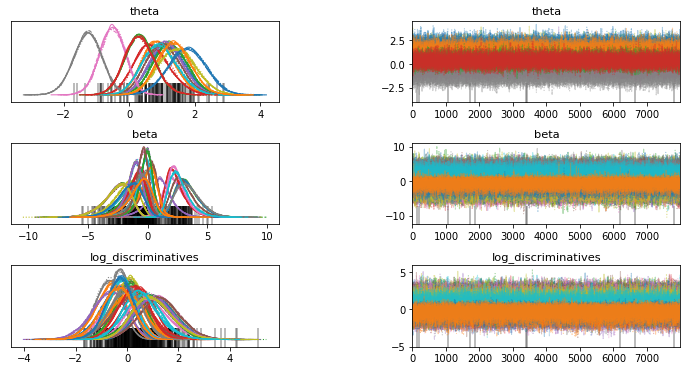

In [ ]:
axes = az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
az.summary(idata, var_names=['theta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],1.180,0.531,0.203,2.181,0.004,0.003,17825.0,28333.0,1.0
theta[1],0.902,0.496,-0.008,1.843,0.004,0.003,15625.0,27710.0,1.0
theta[2],1.254,0.518,0.296,2.235,0.004,0.003,18845.0,29397.0,1.0
theta[3],0.704,0.538,-0.300,1.707,0.004,0.003,14418.0,26881.0,1.0
theta[4],1.136,0.503,0.226,2.111,0.004,0.003,17740.0,28371.0,1.0
theta[5],1.040,0.520,0.096,2.035,0.004,0.003,17265.0,28069.0,1.0
theta[6],-0.509,0.394,-1.235,0.242,0.004,0.002,12631.0,24324.0,1.0
theta[7],-1.270,0.433,-2.075,-0.446,0.004,0.002,15054.0,26335.0,1.0
theta[8],1.458,0.572,0.369,2.512,0.004,0.003,17362.0,28080.0,1.0
theta[9],0.940,0.531,-0.024,1.965,0.004,0.003,15271.0,26223.0,1.0


In [ ]:
az.summary(idata, var_names=['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-1.572,1.111,-3.706,0.343,0.006,0.005,39948.0,31561.0,1.0
beta[1],-0.988,1.056,-3.118,0.726,0.006,0.005,30168.0,25977.0,1.0
beta[2],3.374,1.024,1.667,5.322,0.006,0.004,29808.0,27979.0,1.0
beta[3],-2.616,1.144,-4.798,-0.643,0.006,0.005,38287.0,29913.0,1.0
beta[4],-2.612,1.148,-4.792,-0.655,0.006,0.005,40692.0,28422.0,1.0
beta[5],-2.613,1.147,-4.769,-0.632,0.006,0.005,39485.0,28349.0,1.0
beta[6],2.260,1.027,0.538,4.395,0.006,0.004,31263.0,26357.0,1.0
beta[7],-1.399,1.244,-3.858,0.768,0.006,0.005,42009.0,32286.0,1.0
beta[8],3.380,1.028,1.650,5.355,0.006,0.005,29256.0,29055.0,1.0
beta[9],-1.217,0.789,-2.747,0.100,0.006,0.004,21301.0,23050.0,1.0


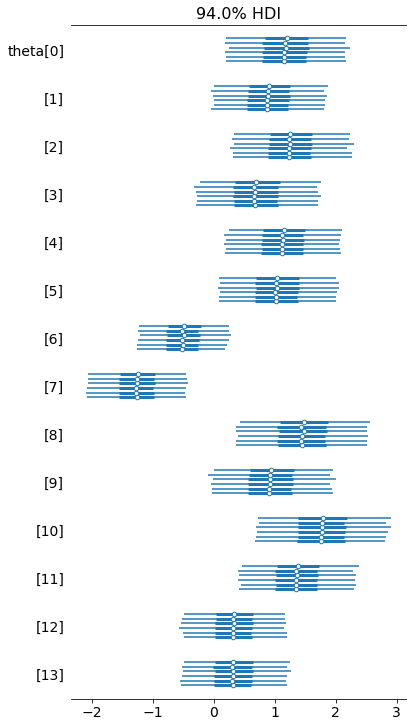

In [ ]:
axes = az.plot_forest(idata, var_names=['theta'])